## FLIGHT TRUST


# Summary

Simple python script that runs a regression to predict actual flight time and probability of delay of airlines by route. This document takes you through each of the steps to run the regression for both of these predictions. The document is divided into two main sections: the development, which show the development of the regression, and the Validations, which shows how we validated the data and created the ROC curves.

# Development

## 1. Import
First, we start by importing all the neccesary libraries to the project


In [1]:
import pandas as pd
import statsmodels.api as sm
from sklearn.cross_validation import train_test_split
import math
import numpy as np
import matplotlib.pyplot as plt


## 2. Extract Data


In [2]:
gdf = pd.read_csv("./CSV/merged.csv")

/Users/gal/anaconda/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (0,1,2,3,4,6,7,12,13,14,15,16,17,19,20,21,22,23,24,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## 3. Select Data

We start by filtering the columns that were considered the most important based on a data analysis made prior to the development of the regression.

We filter by the relevant columns.

In [3]:
df1 = gdf[['AIRLINE_ID','ORIGIN', 'DEST', 'DEP_TIME','ARR_TIME','DEP_DELAY','ARR_DELAY','CANCELLED','DIVERTED','ACTUAL_ELAPSED_TIME']]

Afterwards, we filter by the important airports (ATL, DFW, JFK, LAX and ORD)

In [4]:
df2 = df1.query('(ORIGIN == "ATL" or ORIGIN == "DFW" or ORIGIN == "JFK" or ORIGIN == "LAX" or ORIGIN == "ORD") and (DEST == "ATL" or DEST == "DFW" or DEST == "JFK" or DEST == "LAX" or DEST == "ORD")')

## 4. Sample Data

We now get a random sample Data from the big data set

In [5]:
sampledf = df2.sample(n=10000)
print("Sample Size:" + str(len(sampledf.axes[0])))

Sample Size:10000


## 5. Clean Data

Having the sample data, we proceed to clean the data and make sure there are no invalid data in the dataset

First, we trim the string columns to avoid any unexpected error

In [6]:
sampledf["AIRLINE_ID"] = sampledf.apply(lambda row: str.strip(str(row.AIRLINE_ID)), axis=1)
sampledf["ORIGIN"] = sampledf.apply(lambda row: str.strip(str(row.ORIGIN)), axis=1)
sampledf["DEST"] = sampledf.apply(lambda row: str.strip(str(row.DEST)), axis=1)

Second, we delete any rows with null values

In [7]:
sampledf = sampledf.dropna()

Third, we change the Actual Elapse Time column to an integer

In [8]:
sampledf["ACTUAL_ELAPSED_TIME"] = sampledf.apply(lambda row: int(float(row.ACTUAL_ELAPSED_TIME)), axis=1)

Finally, we clean any invalid Data - any flight that has negative time

In [9]:
sampledf = sampledf[sampledf.ACTUAL_ELAPSED_TIME >= 0]

## 6. Add new Columns

We can now calculate the new columns we need for the regression. Based on a prior data analysis we found that the period of the day is relevant for the delay and flight time of a flight. 

So, we first calculate the flight periods columns, where Morning is from 6 to 12 , Afternoon is from 12 to 19, Night is from 19 to 24, and Dawn is from 24 to 6

In [10]:
sampledf["Morning"]   = sampledf.apply(lambda row: 1 if(not row.CANCELLED and int(row.DEP_TIME) >= 600 and int(row.DEP_TIME) < 1200) else 0, axis=1)
sampledf["Afternoon"] = sampledf.apply(lambda row: 1 if(not row.CANCELLED and int(row.DEP_TIME) >= 1200 and int(row.DEP_TIME) < 1900) else 0, axis=1)
sampledf["Night"]     = sampledf.apply(lambda row: 1 if(not row.CANCELLED and int(row.DEP_TIME) >= 1900 and int(row.DEP_TIME) < 2400) else 0, axis=1)
sampledf["Dawn"]      = sampledf.apply(lambda row: 1 if(not row.CANCELLED and int(row.DEP_TIME) >= 2400 and int(row.DEP_TIME) < 600) else 0, axis=1)

We also calculate the delay column, which is one if a flight was cancelled, diverted, or has delayed over 30 min

In [11]:
sampledf["Delayed"] = sampledf.apply(lambda row: 1 if(row.CANCELLED or row.DIVERTED or row.ARR_DELAY > 30) else 0 , axis=1)
sampledf.columns

Index(['AIRLINE_ID', 'ORIGIN', 'DEST', 'DEP_TIME', 'ARR_TIME', 'DEP_DELAY',
       'ARR_DELAY', 'CANCELLED', 'DIVERTED', 'ACTUAL_ELAPSED_TIME', 'Morning',
       'Afternoon', 'Night', 'Dawn', 'Delayed'],
      dtype='object')

## 7. Dummy Variables

Now we need to create all of the dummy variables for each of the columns

In [12]:
originDummy = pd.get_dummies(sampledf["ORIGIN"], prefix="ORG", drop_first=True)
destDummy = pd.get_dummies(sampledf["DEST"], prefix="DST", drop_first=True)
airlineDummy = pd.get_dummies(sampledf["AIRLINE_ID"], prefix="AIRLN", drop_first=True)

Using the dummy variables, we create a table for the regression by concatenating all of the dummy columns and the dependant variable 

In [13]:
dummyDf = pd.DataFrame()
dummyDf = pd.concat([originDummy,destDummy,airlineDummy,sampledf['Morning'], sampledf['Afternoon'], sampledf['Night'],sampledf['Delayed'],sampledf['ACTUAL_ELAPSED_TIME']], axis=1)
dummyDf.head()

,ORG_DFW,ORG_JFK,ORG_LAX,ORG_ORD,DST_DFW,DST_JFK,DST_LAX,DST_ORD,AIRLN_19790,AIRLN_19805,...,AIRLN_20398,AIRLN_20409,AIRLN_20416,AIRLN_20436,AIRLN_21171,Morning,Afternoon,Night,Delayed,ACTUAL_ELAPSED_TIME
412672,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0,1,0,0,168
3104319,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0,1,0,0,372
5416505,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1,0,0,0,165
3953272,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0,0,1,0,303
667530,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0,0,1,0,411


## 8. Split Test & Learn Datasets

Then, we split the sample data in training and test data set -- Test size is 20% of the hole data set

In [14]:
trainingDF, testDF = train_test_split(dummyDf, test_size = 0.2)

And we make sure all variables are an integer for the regression

In [15]:
trainingDF = trainingDF.applymap(np.int)
testDF = testDF.applymap(np.int)

## 9. 50-50 Data

We now split the data set to make sure that 50% of the rows are delayed flights and 50% are non-delayed flights

We do it for the training data set

In [16]:
trainingDFDelayed =  trainingDF[trainingDF.Delayed == 1].head(500)
trainingDFNotDelayed = trainingDF[trainingDF.Delayed == 0].head(500)

allTraining = [trainingDFNotDelayed,trainingDFDelayed]
trainingDF = pd.concat(allTraining)

print("Training Size:" + str(len(trainingDF.axes[0])))

Training Size:1000


And for the testing data set

In [17]:
testDFDelayed = testDF[testDF.Delayed == 1].head(100)
testDFNotDelayed = testDF[testDF.Delayed == 0].head(100)

allTest = [testDFDelayed,testDFNotDelayed]
testDF = pd.concat(allTest)

print("Testing Size:" + str(len(testDF.axes[0])))

Testing Size:200


## 10. Regression - Delayed

We can finally run the regression for the Delayed dependent Variable

In [18]:
XValues = sm.add_constant(trainingDF[trainingDF.columns.difference(['Delayed','ACTUAL_ELAPSED_TIME'])], prepend=False)
resultDelayed = sm.OLS(trainingDF['Delayed'], XValues).fit()
print(resultDelayed.summary())

                            OLS Regression Results                            
Dep. Variable:                Delayed   R-squared:                       0.238
Model:                            OLS   Adj. R-squared:                  0.221
Method:                 Least Squares   F-statistic:                     14.52
Date:                Tue, 29 Nov 2016   Prob (F-statistic):           9.82e-45
Time:                        22:08:56   Log-Likelihood:                -590.07
No. Observations:                1000   AIC:                             1224.
Df Residuals:                     978   BIC:                             1332.
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
AIRLN_19790    -0.0547      0.145     -0.376      

## 11. Regression - Predicted Total Time (Flight time + taxi)

We run the regression to predict the flight time

In [19]:
XValues = sm.add_constant(trainingDF[trainingDF.columns.difference(['Delayed','ACTUAL_ELAPSED_TIME'])])
resultTime = sm.OLS(trainingDF['ACTUAL_ELAPSED_TIME'], XValues ).fit()
print(resultTime.summary())

                             OLS Regression Results                            
Dep. Variable:     ACTUAL_ELAPSED_TIME   R-squared:                       0.854
Model:                             OLS   Adj. R-squared:                  0.851
Method:                  Least Squares   F-statistic:                     272.2
Date:                 Tue, 29 Nov 2016   Prob (F-statistic):               0.00
Time:                         22:09:16   Log-Likelihood:                -4929.8
No. Observations:                 1000   AIC:                             9904.
Df Residuals:                      978   BIC:                         1.001e+04
Df Model:                           21                                         
Covariance Type:             nonrobust                                         
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
const         162.7184     11.548     14

# VALIDATION AND TESTING

## Validate with Test Data -- Delayed Prediction

Using the regression, we predict the outcome for the testing data set for the delay prediction.

In [24]:
#Copy of the testing data set
validateDataDelay = testDF.copy()

#Get a subset of the data without the validation data 
subsetPredictDelay = validateDataDelay[validateDataDelay.columns.difference(['Delayed','ACTUAL_ELAPSED_TIME'])]

#Predict the outcome with the regression and put the result in a new column
subsetPredictDelay['Calculated_Delay'] = subsetPredictDelay.apply(lambda row: (row * resultDelayed.params).sum(),axis=1)

#Add the real outcome in a new column
subsetPredictDelay["Real_Delayed"] = testDF["Delayed"]

subsetPredictDelay.head()[["Real_Delayed","Calculated_Delay"]]


/Users/gal/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,Real_Delayed,Calculated_Delay
5350147,1,0.143945
2506044,1,-0.399001
1467895,1,-0.649615
958060,1,0.132859
2153379,1,-0.435742


## Validate with Test Data -- Predicted Total Time (Flight time + taxi)

Using the regression, we predict the outcome for the testing data set for the flight time prediction.

In [23]:
#Copy of the testing data set
validateDataTime = testDF.copy()

subsetPredictTime = validateDataTime[validateDataTime.columns.difference(['Delayed','ACTUAL_ELAPSED_TIME'])]
subsetPredictTime["const"] = 1
subsetPredictTime['Calculated'] = subsetPredictTime.apply(lambda row: (row * resultTime.params).sum(),axis=1)

subsetPredictTime["ACTUAL_ELAPSED_TIME"] = validateDataTime["ACTUAL_ELAPSED_TIME"]
subsetPredictTime["Difference"] = subsetPredictTime.apply(lambda row: abs(row.ACTUAL_ELAPSED_TIME - row.Calculated), axis=1)

subsetPredictTime.head()[["ACTUAL_ELAPSED_TIME","Calculated","Difference"]]

/Users/gal/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,ACTUAL_ELAPSED_TIME,Calculated,Difference
5350147,367,358.562598,8.437402
2506044,249,234.707071,14.292929
1467895,203,237.194454,34.194454
958060,258,263.381389,5.381389
2153379,114,121.813684,7.813684


## Predicted Total Time Graph (Testing set is used here)

Now we create a testing graph where we can see how much if the data is under a specific difference of time. 

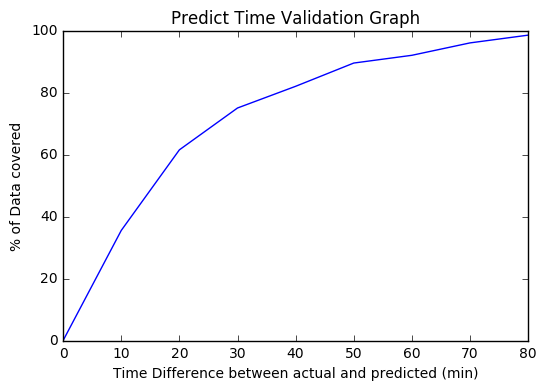

In [30]:
#Create dataframe with the difference ranges
roicTime = pd.DataFrame({"Values":range(int(subsetPredictTime["Difference"].min()),int(subsetPredictTime["Difference"].max()),10)})
roicTime["Percentage"] = roicTime.apply(lambda row: len(subsetPredictTime[subsetPredictTime.Difference < row.Values]["Difference"]) / len(subsetPredictTime["Difference"]) * 100, axis=1 )

plt.plot(roicTime.Values,roicTime.Percentage)
plt.xlabel("Time Difference between actual and predicted (min)")
plt.ylabel("% of Data covered")
plt.title('Predict Time Validation Graph')
plt.show()

## Calculate ROC -- Predicted Delay (Testing set is used here)

We calculated the Truth Table

In [33]:
roicDelay = pd.DataFrame({"Values": np.arange(subsetPredictDelay["Calculated_Delay"].min(),subsetPredictDelay["Calculated_Delay"].max(),0.1)})

#True Positive
roicDelay["T_P"] = roicDelay.apply(lambda row:len(subsetPredictDelay[(subsetPredictDelay.Calculated_Delay > row.Values) & (subsetPredictDelay.Real_Delayed == 1)]),axis=1)
#False Positive
roicDelay["F_P"] = roicDelay.apply(lambda row:len(subsetPredictDelay[(subsetPredictDelay.Calculated_Delay > row.Values) & (subsetPredictDelay.Real_Delayed == 0)]),axis=1)
#True Negative
roicDelay["T_N"] = roicDelay.apply(lambda row:len(subsetPredictDelay[(subsetPredictDelay.Calculated_Delay < row.Values) & (subsetPredictDelay.Real_Delayed == 0)]),axis=1)
#False Negative
roicDelay["F_N"] = roicDelay.apply(lambda row:len(subsetPredictDelay[(subsetPredictDelay.Calculated_Delay < row.Values) & (subsetPredictDelay.Real_Delayed == 1)]),axis=1)

roicDelay

,Values,T_P,F_P,T_N,F_N
0,-0.717371,100,98,0,0
1,-0.617371,97,91,9,3
2,-0.517371,96,75,25,4
3,-0.417371,85,58,42,15
4,-0.317371,69,44,56,31
5,-0.217371,53,20,80,47
6,-0.117371,50,7,93,50
7,-0.017371,44,5,95,56
8,0.082629,30,2,98,70
9,0.182629,3,1,99,97


Finally, we graph the ROC line

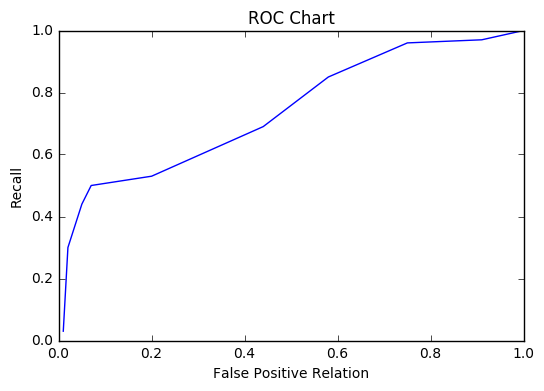

In [35]:
#False Posive Ration 
roicDelay["F_P_R"] = roicDelay.apply(lambda row: row["F_P"]/(row["F_P"] + row["T_N"]),axis=1)
#Recall Ration
roicDelay["Recall"] = roicDelay.apply(lambda row: row["T_P"]/(row["T_P"] + row["F_N"]),axis=1)

plt.plot(roicDelay["F_P_R"],roicDelay["Recall"] )
plt.xlabel("False Positive Relation")
plt.ylabel("Recall")
plt.title('ROC Chart')
plt.show()